Using cpu device
Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)
tensorboard log dir : log/fit/20220117-050234
Epoch 1
-------------------------------
loss: 2.306366  [    0/60000]
loss: 2.252696  [16000/60000]
loss: 2.189614  [32000/60000]
loss: 2.086876  [48000/60000]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.988975 

Epoch 2
-------------------------------
loss: 1.898465  [    0/60000]
loss: 1.970024  [16000/60000]
loss: 1.624961  [32000/60000]
loss: 1.558996  [48000/60000]
Test Error: 
 Accuracy: 61.2%, Avg loss: 1.489960 

Epoch 3
-------------------------------
loss: 1.424864  [    0/60000]
loss: 1.3489

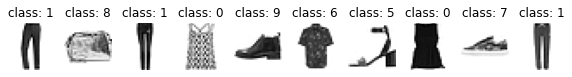

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import datetime, os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

train_data = datasets.FashionMNIST(
    root="/home/jovyan/mlops-kubeflow/data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="/home/jovyan/mlops-kubeflow/data/FashionMNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for (x_train, y_train) in train_dataloader:
    print("Shape of X [N, C, H, W]: ", x_train.shape)
    print("Shape of y: ", y_train.shape, y_train.dtype)
    break

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title("class: " + str(y_train[i].item()))
    plt.axis("off")

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
#         output = F.log_softmax(logits, dim=1)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            # 텐서보드에 Train Loss / per epoch 로그 기록 
            writer.add_scalar('Train/Loss', loss, t+1)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_accuracy = 100. * correct 
    # 텐서보드에 Test 로그 기록
    writer.add_scalar('Test/Loss', test_loss, t+1)
    writer.add_scalar('Test/Accuracy', test_accuracy, t+1)
    writer.flush()
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

date_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "log/fit/" + date_folder
print(f"tensorboard log dir : {log_dir}")
writer = SummaryWriter(log_dir)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

writer.close()

print("Done!")